### Medicaid

In [16]:
import pandas as pd
from linearmodels.panel import PanelOLS
file_path = 'data/medicaid.csv'
data = pd.read_csv(file_path, encoding='latin1')
display(data.head())
data['PostEvent'] = (data['year'] >= data['AdoptedYear']).astype(int)
data = data.set_index(["County", "year"])
data = data.dropna(subset=['uninsured', 'median_income', 'unemployment', 'PostEvent'])
formula = "uninsured ~ PostEvent + median_income + unemployment + EntityEffects + TimeEffects"
mod = PanelOLS.from_formula(formula, data=data)
results = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
print(results.summary)

State              id  unemployment  median_income  uninsured  year  \
0  Alabama  0500000US01003           5.6          50900       12.0  2011   
1  Alabama  0500000US01015           7.5          39037       15.6  2011   
2  Alabama  0500000US01043           5.5          40054       12.6  2011   
3  Alabama  0500000US01049           7.1          36541       19.6  2011   
4  Alabama  0500000US01051           6.5          57405       10.6  2011   

           County MedicaidStatus  AdoptedYear  SID  
0  Baldwin County    Not Adopted            0    1  
1  Calhoun County    Not Adopted            0    2  
2  Cullman County    Not Adopted            0    3  
3   DeKalb County    Not Adopted            0    4  
4   Elmore County    Not Adopted            0    5

                          PanelOLS Estimation Summary                           
Dep. Variable:              uninsured   R-squared:                        0.1090
Estimator:                   PanelOLS   R-squared (Between):             -0.7782
No. Observations:                7341   R-squared (Within):               0.2476
Date:                Thu, Nov 21 2024   R-squared (Overall):             -0.7234
Time:                        20:09:17   Log-likelihood                -1.622e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      271.92
Entities:                         660   P-value                           0.0000
Avg Obs:                       11.123   Distribution:                  F(3,6670)
Min Obs:                       1.0000                                           
Max Obs:                       81.000   F-statistic (robust):             23.104
                            

### Panel Event Study

/Users/pranjal/myenv/lib/python3.11/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


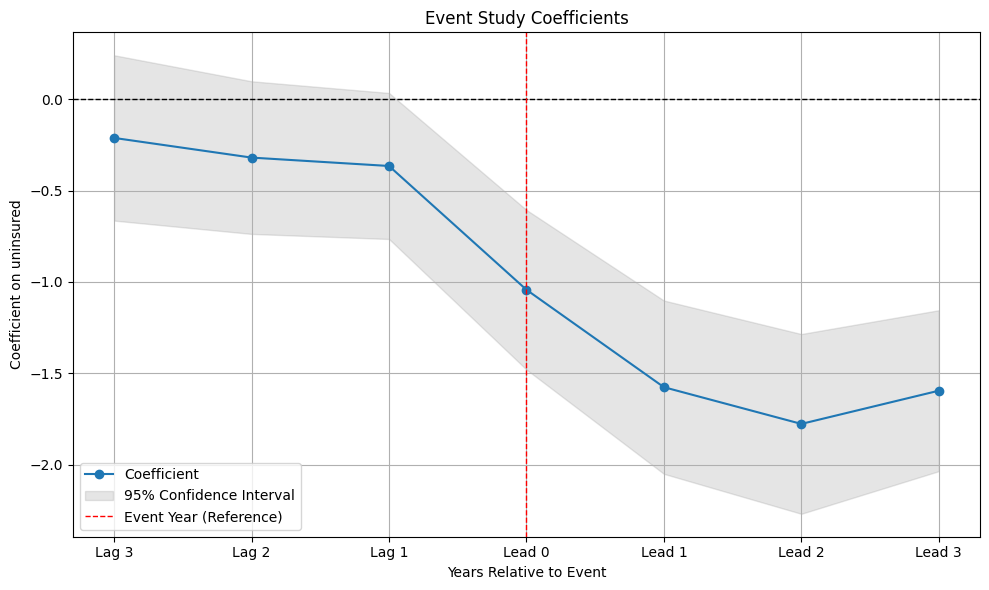

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

file_path = 'data/medicaid.csv'
data = pd.read_csv(file_path, encoding='latin1')
data['AdoptedYear'] = data['AdoptedYear'].fillna(0)
data['time_to_event'] = data.apply(lambda row: row['year'] - row['AdoptedYear'] if row['AdoptedYear'] != 0 else None, axis=1)
max_lag = 3
max_lead = 3
for i in range(-max_lag, max_lead + 1):
    if i < 0:
        data[f'Lag {-i}'] = data.apply(lambda row: 1 if row['time_to_event'] == i else 0 if row['time_to_event'] is not None else None, axis=1)
    elif i == 0:
        data['Lead 0'] = data.apply(lambda row: 1 if row['time_to_event'] == i else 0 if row['time_to_event'] is not None else None, axis=1)
    elif i > 0:
        data[f'Lead {i}'] = data.apply(lambda row: 1 if row['time_to_event'] == i else 0 if row['time_to_event'] is not None else None, axis=1)
data['PostEvent'] = data.apply(lambda row: 1 if row['time_to_event'] >= 0 else 0 if row['time_to_event'] is not None else None, axis=1)
columns_to_include = ['uninsured', 'median_income', 'unemployment', 'County', 'year', 'AdoptedYear', 'PostEvent', 'time_to_event'] + [f'Lag {i}' for i in range(1, max_lag + 1)] + ['Lead 0'] + [f'Lead {i}' for i in range(1, max_lead + 1)]
data_final = data[columns_to_include]
data_final = data_final.set_index(["County", "year"])
lags = " + ".join([f"`Lag {i}`" for i in range(1, max_lag + 1)])
leads = " + ".join([f"`Lead {i}`" for i in range(1, max_lead + 1)] + ["`Lead 0`"])
covariates = " + median_income + unemployment"
formula = f"uninsured ~ {lags} + {leads} + {covariates} + EntityEffects + TimeEffects"
mod = PanelOLS.from_formula(formula, data_final)
results = mod.fit(cov_type='clustered', cluster_entity=True)
coef = results.params
conf_int = results.conf_int()
lags_leads = coef.loc[[f"Lag {i}" for i in range(1, max_lag + 1)] + ["Lead 0"] + [f"Lead {i}" for i in range(1, max_lead + 1)]]
conf_int_lags_leads = conf_int.loc[[f"Lag {i}" for i in range(1, max_lag + 1)] + ["Lead 0"] + [f"Lead {i}" for i in range(1, max_lead + 1)]]
x = list(range(-max_lag, max_lead + 1))
lower = conf_int_lags_leads.iloc[:, 0].values
upper = conf_int_lags_leads.iloc[:, 1].values
plt.figure(figsize=(10, 6))
y = lags_leads.values
plt.plot(x, y, marker='o', label='Coefficient')
plt.fill_between(x, lower, upper, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Event Year (Reference)')
plt.xlabel('Years Relative to Event')
plt.ylabel('Coefficient on uninsured')
plt.title('Event Study Coefficients')
plt.xticks(x, labels=[f"Lag {abs(i)}" if i < 0 else f"Lead {i}" if i > 0 else "Lead 0" for i in x])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Divorce

In [64]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Load the dataset
file_path = 'data/divorce.rda'
data_rda = rdata.read_rda(file_path)
data = pd.DataFrame(data_rda['divorce'])

# Create PostEvent variable
data['PostEvent'] = (data['year'] >= data['year']).astype(int)  # Assuming 'year' is analogous to the event year

# Set panel indices
data = data.set_index(["stfips", "year"])

# Drop rows with missing values in key variables
data = data.dropna(subset=['asmrs', 'pcinc', 'asmrh', 'cases', 'PostEvent'])

# Define the TWFE model formula
formula = "asmrs ~ PostEvent + pcinc + asmrh + cases + EntityEffects + TimeEffects"

# Fit the TWFE model
mod = PanelOLS.from_formula(formula, data=data)
results = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

# Print the results summary
print(results.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  asmrs   R-squared:                        0.0313
Estimator:                   PanelOLS   R-squared (Between):             -0.0614
No. Observations:                1617   R-squared (Within):               0.2337
Date:                Thu, Nov 21 2024   R-squared (Overall):              0.0736
Time:                        20:43:16   Log-likelihood                   -6110.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      16.512
Entities:                          49   P-value                           0.0000
Avg Obs:                       33.000   Distribution:                  F(3,1533)
Min Obs:                       33.000                                           
Max Obs:                       33.000   F-statistic (robust):             4.1288
                            

/Users/pranjal/myenv/lib/python3.11/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "tbl_df". The constructor for class "tbl" will be used instead.
  warnings.warn(
/Users/pranjal/myenv/lib/python3.11/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "tbl". The constructor for class "data.frame" will be used instead.
  warnings.warn(


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import rdata

# Hardcoded adoption years dictionary
adoption_years = {
    "Alabama": 1971,
    "Arizona": 1973,
    "Arkansas": None,  # NRS
    "California": 1970,
    "Colorado": 1971,
    "Connecticut": 1973,
    "Delaware": None,  # NRS
    "District of Columbia": 1977,
    "Florida": 1971,
    "Georgia": 1973,
    "Idaho": 1971,
    "Illinois": 1984,
    "Indiana": 1973,
    "Iowa": 1970,
    "Kansas": 1969,
    "Kentucky": 1972,
    "Louisiana": None,  # PRE
    "Maine": 1973,
    "Maryland": None,  # PRE
    "Massachusetts": 1975,
    "Michigan": 1972,
    "Minnesota": 1974,
    "Mississippi": None,  # NRS
    "Missouri": 1973,
    "Montana": 1975,
    "Nebraska": 1972,
    "Nevada": 1973,
    "New Hampshire": 1971,
    "New Jersey": 1971,
    "New Mexico": 1973,
    "New York": None,  # NRS
    "North Carolina": None,  # PRE
    "North Dakota": 1971,
    "Ohio": 1974,
    "Oklahoma": None,  # PRE
    "Oregon": 1973,
    "Pennsylvania": 1980,
    "Rhode Island": 1976,
    "South Carolina": 1969,
    "South Dakota": 1985,
    "Tennessee": None,  # NRS
    "Texas": 1974,
    "Utah": None,  # PRE
    "Vermont": None,  # PRE
    "Virginia": None,  # PRE
    "Washington": 1973,
    "West Virginia": None,  # PRE
    "Wisconsin": 1977,
    "Wyoming": 1977,
}

# Load and prepare the dataset
file_path = 'data/divorce.rda'
data_rda = rdata.read_rda(file_path)
data = pd.DataFrame(data_rda['divorce'])

print("Initial Data:")
print(data.head())

# Map adoption years to the dataset
data['AdoptionYear'] = data['stfips'].map(adoption_years)

# Create 'time_to_event' where applicable, leave as NaN for 'NRS' states
data['time_to_event'] = data.apply(
    lambda row: row['year'] - row['AdoptionYear'] if not pd.isnull(row['AdoptionYear']) else None, axis=1
)

print("\nAfter Mapping AdoptionYear and Creating time_to_event:")
print(data[['stfips', 'year', 'AdoptionYear', 'time_to_event']].head())

# Define max lag and lead
max_lag = 15
max_lead = 10

# Create Lag and Lead dummy variables
for i in range(-max_lag, max_lead + 1):
    if i < 0:
        data[f'Lag {-i}'] = data.apply(
            lambda row: 1 if row['time_to_event'] == i else 0 if row['time_to_event'] is not None else None, axis=1
        )
    elif i > 0:
        data[f'Lead {i}'] = data.apply(
            lambda row: 1 if row['time_to_event'] == i else 0 if row['time_to_event'] is not None else None, axis=1
        )

# Reference period: Lag 1
data['ReferencePeriod'] = data.apply(
    lambda row: 1 if row['time_to_event'] == -1 else 0 if row['time_to_event'] is not None else None,
    axis=1
)

# Create a 'PostEvent' dummy variable
data['PostEvent'] = data.apply(
    lambda row: 1 if row['time_to_event'] is not None and row['time_to_event'] >= 0 else 0 if row['time_to_event'] is not None else None,
    axis=1
)

print("\nAfter Creating Lag, Lead, and PostEvent Variables:")
print(data[[f'Lag {i}' for i in range(2, 6)] + [f'Lead {i}' for i in range(1, 6)] + ['PostEvent']].head())

# Select relevant columns
columns_to_include = ['asmrs', 'pcinc', 'asmrh', 'cases', 'stfips', 'year', 'time_to_event', 'PostEvent', 'ReferencePeriod'] + \
                     [f'Lag {i}' for i in range(2, max_lag + 1)] + \
                     [f'Lead {i}' for i in range(1, max_lead + 1)]
data_final = data[columns_to_include]

print("\nFiltered Data Columns:")
print(data_final.head())

# Set up panel indices
data_final = data_final.set_index(['stfips', 'year'])

print("\nAfter Setting Panel Indices:")
print(data_final.head())

# Create TWFE model formula
lags = " + ".join([f"`Lag {i}`" for i in range(2, max_lag + 1)])  # Start from Lag 2 to omit reference period
leads = " + ".join([f"`Lead {i}`" for i in range(1, max_lead + 1)])
covariates = "pcinc + asmrh + cases"
formula = f"asmrs ~ {lags} + {leads} + {covariates} + EntityEffects + TimeEffects"
print("\nFormula for TWFE:")
print(formula)

# Fit the TWFE model
try:
    mod = PanelOLS.from_formula(formula, data_final)
    results = mod.fit(cov_type='clustered', cluster_entity=True)
    print("\nModel Results Summary:")
    print(results.summary)
except ValueError as e:
    print("\nError in Model Fitting:")
    print(e)
    print("\nExamine Data for Rank Deficiency:")
    print(data_final.describe(include='all'))


/Users/pranjal/myenv/lib/python3.11/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "tbl_df". The constructor for class "tbl" will be used instead.
  warnings.warn(
/Users/pranjal/myenv/lib/python3.11/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "tbl". The constructor for class "data.frame" will be used instead.
  warnings.warn(


Initial Data:
   stfips    year  post      asmrs         pcinc     asmrh     cases
1     1.0  1964.0   0.0  35.639885  12406.178537  5.007341  0.012312
2     1.0  1965.0   0.0  41.543755  13070.206738  4.425367  0.010419
3     1.0  1966.0   0.0  34.252335  13526.663217  4.874819  0.009900
4     1.0  1967.0   0.0  34.465023  13918.189823  5.362014  0.009975
5     1.0  1968.0   0.0  40.440105  14684.808682  4.643759  0.012401

After Mapping AdoptionYear and Creating time_to_event:
   stfips    year  AdoptionYear time_to_event
1     1.0  1964.0           NaN          None
2     1.0  1965.0           NaN          None
3     1.0  1966.0           NaN          None
4     1.0  1967.0           NaN          None
5     1.0  1968.0           NaN          None

After Creating Lag, Lead, and PostEvent Variables:
  Lag 2 Lag 3 Lag 4 Lag 5 Lead 1 Lead 2 Lead 3 Lead 4 Lead 5 PostEvent
1  None  None  None  None   None   None   None   None   None      None
2  None  None  None  None   None   None   None

IndexError: list index out of range

In [67]:
# Replace EventYear with a simulated or actual event year for debugging
# Assume stfips 1 had an event in 1966, and other states have varied events
event_years = {1.0: 1966.0, 2.0: 1970.0, 3.0: 1980.0}  # Simulated Event Years
data['EventYear'] = data['stfips'].map(event_years)

# Compute time_to_event relative to EventYear
data['time_to_event'] = data['year'] - data['EventYear']

# Correctly create lag and lead dummies
for i in range(-max_lag, max_lead + 1):
    if i < 0:
        data[f'Lag {-i}'] = (data['time_to_event'] == i).astype(int)
    elif i > 0:
        data[f'Lead {i}'] = (data['time_to_event'] == i).astype(int)

# Reference period: Lag 1
data['ReferencePeriod'] = (data['time_to_event'] == -1).astype(int)

# Create PostEvent variable
data['PostEvent'] = (data['time_to_event'] >= 0).astype(int)

# Verify new dummies
print("\nAfter Fixing Lag and Lead Variables:")
print(data[[f'Lag {i}' for i in range(1, 6)] + [f'Lead {i}' for i in range(1, 6)] + ['PostEvent', 'time_to_event']].head())

# Proceed with data filtering, indexing, and regression as before
columns_to_include = ['asmrs', 'pcinc', 'asmrh', 'cases', 'stfips', 'year', 'time_to_event', 'PostEvent', 'ReferencePeriod'] + \
                     [f'Lag {i}' for i in range(2, max_lag + 1)] + \
                     [f'Lead {i}' for i in range(1, max_lead + 1)]
data_final = data[columns_to_include].dropna()

data_final = data_final.set_index(['stfips', 'year'])

lags = " + ".join([f"`Lag {i}`" for i in range(2, max_lag + 1)])
leads = " + ".join([f"`Lead {i}`" for i in range(1, max_lead + 1)])
covariates = "pcinc + asmrh + cases"
formula = f"asmrs ~ {lags} + {leads} + {covariates} + EntityEffects + TimeEffects"

try:
    mod = PanelOLS.from_formula(formula, data_final)
    results = mod.fit(cov_type='clustered', cluster_entity=True)
    print("\nModel Results Summary:")
    print(results.summary)
except ValueError as e:
    print("\nError in Model Fitting:")
    print(e)



After Fixing Lag and Lead Variables:
   Lag 1  Lag 2  Lag 3  Lag 4  Lag 5  Lead 1  Lead 2  Lead 3  Lead 4  Lead 5  \
1      0      1      0      0      0       0       0       0       0       0   
2      1      0      0      0      0       0       0       0       0       0   
3      0      0      0      0      0       0       0       0       0       0   
4      0      0      0      0      0       1       0       0       0       0   
5      0      0      0      0      0       0       1       0       0       0   

   PostEvent  time_to_event  
1          0           -2.0  
2          0           -1.0  
3          1            0.0  
4          1            1.0  
5          1            2.0  

Error in Model Fitting:
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.


In [68]:
data

stfips    year  post      asmrs         pcinc     asmrh     cases  \
1        1.0  1964.0   0.0  35.639885  12406.178537  5.007341  0.012312   
2        1.0  1965.0   0.0  41.543755  13070.206738  4.425367  0.010419   
3        1.0  1966.0   0.0  34.252335  13526.663217  4.874819  0.009900   
4        1.0  1967.0   0.0  34.465023  13918.189823  5.362014  0.009975   
5        1.0  1968.0   0.0  40.440105  14684.808682  4.643759  0.012401   
...      ...     ...   ...        ...           ...       ...       ...   
1613    56.0  1992.0   1.0  33.149574  31181.450546  1.970134  0.028996   
1614    56.0  1993.0   1.0  63.909775  31666.776231  3.020953  0.026672   
1615    56.0  1994.0   1.0  81.793816  31959.528356  3.501871  0.023643   
1616    56.0  1995.0   1.0  30.630585  32327.659531  0.740606  0.020965   
1617    56.0  1996.0   1.0  49.669003  32667.248279  2.663140  0.018639   

      EventYear  time_to_event  Lag 15  ...  Lead 3  Lead 4  Lead 5  Lead 6  \
1        1966.0           -2.0       0  ...       0       0       0       0   
2        1966.0           -1.0       0  ...       0       0       0       0   
3        1966.0            0.0       0  ...       0       0       0       0   
4        1966.0            1.0       0  ...       0       0       0       0   
5        1966.0            2.0       0  ...       0       0       0       0   
...         ...            ...     ...  ...     ...     ...     ...     ...   
1613        NaN            NaN       0  ...       0       0       0       0   
1614        NaN            NaN       0  ...       0       0       0       0   
1615        NaN            NaN       0  ...       0       0       0       0   
1616        NaN            NaN       0  ...       0       0       0       0   
1617        NaN            NaN       0  ...       0       0       0       0   

      Lead 7  Lead 8  Lead 9  Lead 10  ReferencePeriod  PostEvent  
1          0       0       0        0                0          0  
2          0       0       0        0                1          0  
3          0       0       0        0                0          1  
4          0       0       0        0                0          1  
5          0       0       0        0                0          1  
...      ...     ...     ...      ...              ...        ...  
1613       0       0       0        0                0          0  
1614       0       0       0        0                0          0  
1615       0       0       0        0                0          0  
1616       0       0       0        0                0          0  
1617       0       0       0        0                0          0  

[1617 rows x 36 columns]